In [1]:
import mne
import matplotlib.pyplot as plt

# ─── path to point to your EDF file ───────────────────────────────
edf_path = r"C:\Users\prith\Desktop\COMPLEX DATA ANALYSIS IN PHYSIOLOGY\projects\HRV Analysis\DATA\07-52-53_1 hour.EDF"

# Load the raw EDF (preload so we can slice & plot)
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


In [2]:
# List channels so you know your ECG channel name
print("Available channels:", raw.ch_names)

Available channels: ['ECG', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Marker']


In [3]:
# Choose your ECG channel
ecg_chan = "ECG"  
if ecg_chan not in raw.ch_names:
    raise ValueError(f"Channel '{ecg_chan}' not found; available: {raw.ch_names}")

In [4]:
# Extract data and time array
ecg_data, times = raw.get_data(picks=ecg_chan, return_times=True)

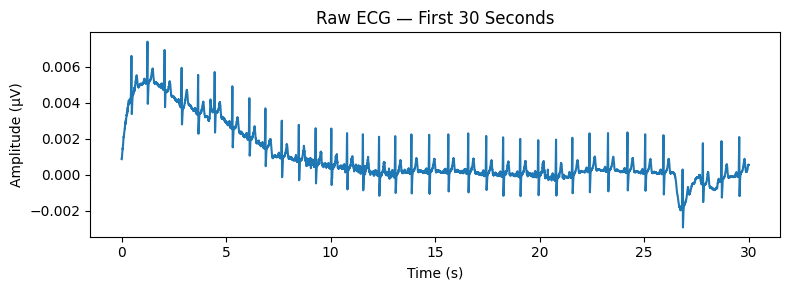

In [5]:
# Plot the first 30 seconds
sf = raw.info["sfreq"]          # sampling frequency (Hz)
window_sec = 30                 # length of snippet in seconds
n_samples = int(sf * window_sec)

plt.figure(figsize=(8, 3))
plt.plot(times[:n_samples], ecg_data[0, :n_samples])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Raw ECG — First {window_sec} Seconds")
plt.tight_layout()
plt.show()


In [6]:
import neurokit2 as nk

# 1. Clean the full raw ECG signal
ecg_clean = nk.ecg_clean(ecg_data[0], sampling_rate=sf, method="biosppy")

# 2. Detect R-peaks across the whole recording
signals, info = nk.ecg_peaks(ecg_clean, sampling_rate=sf)
rpeaks = info["ECG_R_Peaks"]

# 3. Quick sanity check
print(f"Detected {len(rpeaks)} R-peaks")
print("First 10 R-peak sample indices:", rpeaks[:10])


Detected 4139 R-peaks
First 10 R-peak sample indices: [ 467 1234 2054 2868 3658 4450 5297 6109 6876 7660]


SDNN  = 79.90 ms
RMSSD = 45.45 ms
pNN50 = 20.25 %


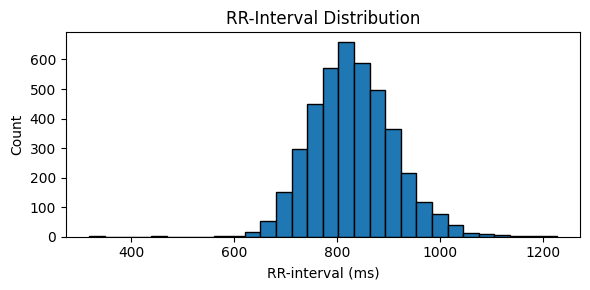

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute RR-intervals (in ms)
rr_intervals = np.diff(rpeaks) / sf * 1000

# 2. Compute time-domain HRV metrics
sdnn  = np.std(rr_intervals, ddof=1)
rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))
pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100

print(f"SDNN  = {sdnn:.2f} ms")
print(f"RMSSD = {rmssd:.2f} ms")
print(f"pNN50 = {pnn50:.2f} %")

# 3. Plot histogram of RR-intervals
plt.figure(figsize=(6, 3))
plt.hist(rr_intervals, bins=30, edgecolor='black')
plt.xlabel("RR-interval (ms)")
plt.ylabel("Count")
plt.title("RR-Interval Distribution")
plt.tight_layout()
plt.show()


Step 5: Frequency‐Domain HRV Analysis

All columns returned:
 ['HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF'] 



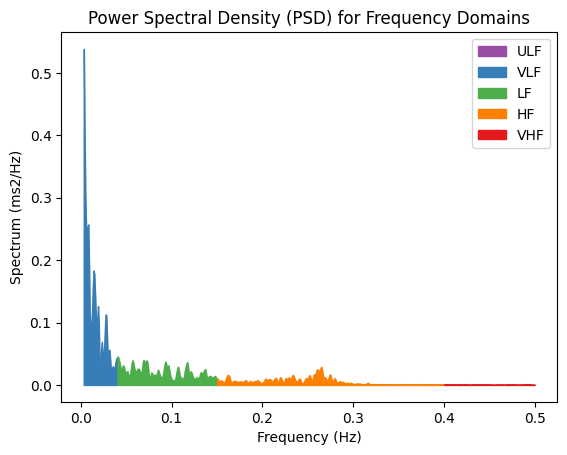

In [8]:
import neurokit2 as nk

# 1. Compute frequency‐domain metrics with Welch’s method,
#    including normalized units
fd = nk.hrv_frequency(
    rpeaks,
    sampling_rate=sf,
    psd_method="welch",
    normalize=True,   # <-- add this
    show=True
)

# 2. Inspect what columns you got
print("All columns returned:\n", fd.columns.tolist(), "\n")

In [9]:
# Print the key spectral indices using the exact column names
print(fd[[
    "HRV_VLF",    # Very low-frequency power (ms^2)
    "HRV_LF",     # Low-frequency power (ms^2)
    "HRV_HF",     # High-frequency power (ms^2)
    "HRV_LFHF",   # LF/HF ratio
    "HRV_LFn",    # LF (nu)
    "HRV_HFn"     # HF (nu)
]])



    HRV_VLF   HRV_LF    HRV_HF  HRV_LFHF   HRV_LFn   HRV_HFn
0  0.002596  0.00132  0.000951  1.387897  0.196695  0.141721


Non–Linear HRV Measures

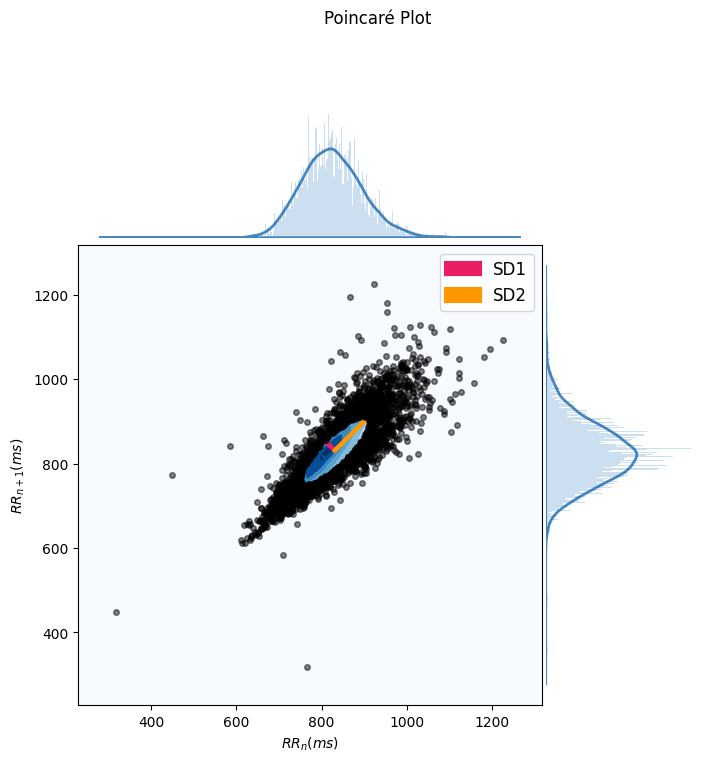

In [10]:
import neurokit2 as nk

# 1. Compute non-linear metrics and show plots
nl = nk.hrv_nonlinear(
    rpeaks,
    sampling_rate=sf,
    show=True   # this will plot the Poincaré plot
)



In [11]:
# Print all available non-linear metric column names
print("Non-linear metric columns:")
for col in nl.columns:
    print(" -", col)


Non-linear metric columns:
 - HRV_SD1
 - HRV_SD2
 - HRV_SD1SD2
 - HRV_S
 - HRV_CSI
 - HRV_CVI
 - HRV_CSI_Modified
 - HRV_PIP
 - HRV_IALS
 - HRV_PSS
 - HRV_PAS
 - HRV_GI
 - HRV_SI
 - HRV_AI
 - HRV_PI
 - HRV_C1d
 - HRV_C1a
 - HRV_SD1d
 - HRV_SD1a
 - HRV_C2d
 - HRV_C2a
 - HRV_SD2d
 - HRV_SD2a
 - HRV_Cd
 - HRV_Ca
 - HRV_SDNNd
 - HRV_SDNNa
 - HRV_DFA_alpha1
 - HRV_MFDFA_alpha1_Width
 - HRV_MFDFA_alpha1_Peak
 - HRV_MFDFA_alpha1_Mean
 - HRV_MFDFA_alpha1_Max
 - HRV_MFDFA_alpha1_Delta
 - HRV_MFDFA_alpha1_Asymmetry
 - HRV_MFDFA_alpha1_Fluctuation
 - HRV_MFDFA_alpha1_Increment
 - HRV_DFA_alpha2
 - HRV_MFDFA_alpha2_Width
 - HRV_MFDFA_alpha2_Peak
 - HRV_MFDFA_alpha2_Mean
 - HRV_MFDFA_alpha2_Max
 - HRV_MFDFA_alpha2_Delta
 - HRV_MFDFA_alpha2_Asymmetry
 - HRV_MFDFA_alpha2_Fluctuation
 - HRV_MFDFA_alpha2_Increment
 - HRV_ApEn
 - HRV_SampEn
 - HRV_ShanEn
 - HRV_FuzzyEn
 - HRV_MSEn
 - HRV_CMSEn
 - HRV_RCMSEn
 - HRV_CD
 - HRV_HFD
 - HRV_KFD
 - HRV_LZC


In [12]:
# Select key non-linear metrics using the exact column names
selected_nl = nl[[
    "HRV_SD1",         # Poincaré short-term (ms)
    "HRV_SD2",         # Poincaré long-term (ms)
    "HRV_SD1SD2",      # SD1/SD2 ratio
    "HRV_SampEn",      # Sample Entropy
    "HRV_ApEn",        # Approximate Entropy
    "HRV_DFA_alpha1",  # DFA short-term exponent
    "HRV_DFA_alpha2",  # DFA long-term exponent
    "HRV_HFD",         # Higuchi fractal dimension
    "HRV_LZC"          # Lempel–Ziv complexity
]]

print("Selected Non-Linear HRV Metrics:")
print(selected_nl)


Selected Non-Linear HRV Metrics:
     HRV_SD1     HRV_SD2  HRV_SD1SD2  HRV_SampEn  HRV_ApEn  HRV_DFA_alpha1  \
0  32.143527  108.331719    0.296714    1.363944  1.461856        1.115031   

   HRV_DFA_alpha2   HRV_HFD   HRV_LZC  
0        0.985841  1.765623  0.609737  


Aggregate All Metrics & Export to CSV

In [13]:
import pandas as pd

# 1. Gather your computed metrics:
metrics = {
    # Time-domain
    "SDNN (ms)": sdnn,
    "RMSSD (ms)": rmssd,
    "pNN50 (%)": pnn50,
    # Frequency-domain (from fd DataFrame)
    "VLF (ms²)": fd["HRV_VLF"].iloc[0],
    "LF (ms²)":  fd["HRV_LF"].iloc[0],
    "HF (ms²)":  fd["HRV_HF"].iloc[0],
    "LF/HF":     fd["HRV_LFHF"].iloc[0],
    "LF (nu)":   fd["HRV_LFn"].iloc[0],
    "HF (nu)":   fd["HRV_HFn"].iloc[0],
}

# 2. Add the non-linear metrics you selected:
metrics.update(selected_nl.iloc[0].to_dict())

# 3. Create a DataFrame
df_metrics = pd.DataFrame([metrics])

# 4. Save to CSV
output_path = "hrv_metrics_summary.csv"
df_metrics.to_csv(output_path, index=False)
print(f"All HRV metrics saved to '{output_path}'.")

# 5. (Optional) Display the table
print("\nSummary of HRV Metrics:")
print(df_metrics.round(3))


All HRV metrics saved to 'hrv_metrics_summary.csv'.

Summary of HRV Metrics:
   SDNN (ms)  RMSSD (ms)  pNN50 (%)  VLF (ms²)  LF (ms²)  HF (ms²)  LF/HF  \
0     79.897      45.452     20.251      0.003     0.001     0.001  1.388   

   LF (nu)  HF (nu)  HRV_SD1  HRV_SD2  HRV_SD1SD2  HRV_SampEn  HRV_ApEn  \
0    0.197    0.142   32.144  108.332       0.297       1.364     1.462   

   HRV_DFA_alpha1  HRV_DFA_alpha2  HRV_HFD  HRV_LZC  
0           1.115           0.986    1.766     0.61  


Visualize HRV Metrics Over Time Windows

C:\Users\prith\AppData\Local\Temp\ipykernel_10124\3932388913.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "LF/HF":            float(nk.hrv_frequency(rpeaks_win, sampling_rate=sf, psd_method="welch", normalize=True, show=False)["HRV_LFHF"]),
C:\Users\prith\AppData\Local\Temp\ipykernel_10124\3932388913.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "LF/HF":            float(nk.hrv_frequency(rpeaks_win, sampling_rate=sf, psd_method="welch", normalize=True, show=False)["HRV_LFHF"]),
C:\Users\prith\AppData\Local\Temp\ipykernel_10124\3932388913.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "LF/HF":            float(nk.hrv_frequency(rpeaks_win, sampling_rate=sf, psd_method="welch"

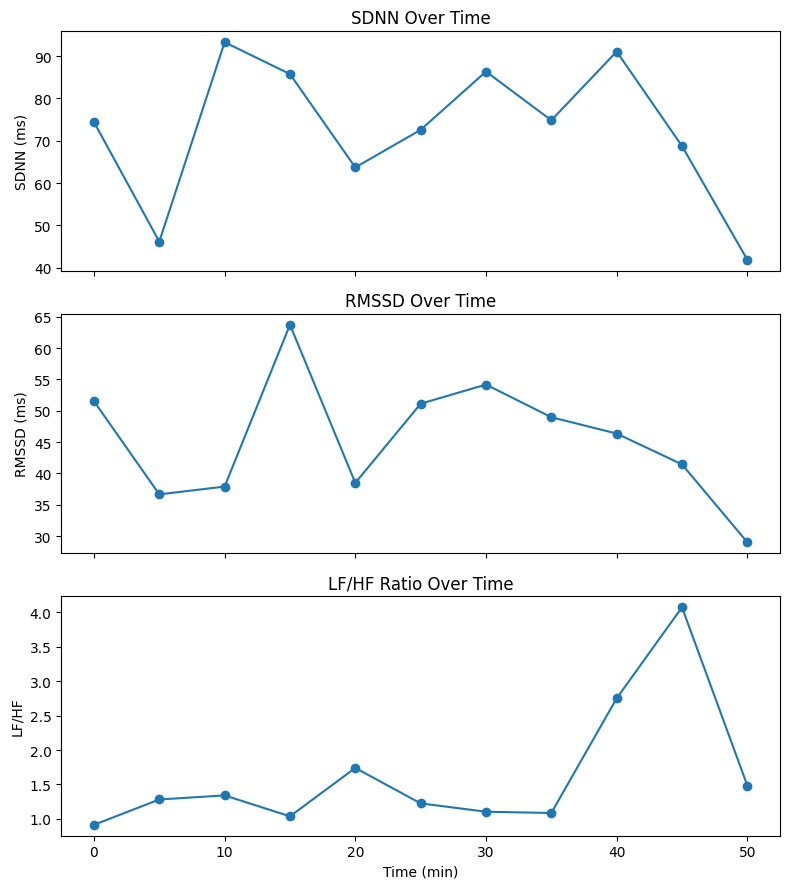

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Define window
window_sec = 5 * 60                 # 5 minutes
window_samples = int(window_sec * sf / sf * sf)  # just window_sec * sf

# 2. Split R-peaks into windows
times_r = rpeaks / sf               # R-peak times in seconds
n_windows = int((times[-1]) // window_sec)

# Prepare storage
rows = []

for w in range(n_windows):
    start_t = w * window_sec
    end_t   = (w + 1) * window_sec
    # select peaks in this window
    mask = (times_r >= start_t) & (times_r < end_t)
    rpeaks_win = rpeaks[mask]
    if len(rpeaks_win) < 10:  # skip if too few beats
        continue
    rr_win = np.diff(rpeaks_win) / sf * 1000

    # compute metrics
    row = {
        "Window":           w,
        "Start_min":        start_t / 60,
        "SDNN":             np.std(rr_win, ddof=1),
        "RMSSD":            np.sqrt(np.mean(np.diff(rr_win)**2)),
        "LF/HF":            float(nk.hrv_frequency(rpeaks_win, sampling_rate=sf, psd_method="welch", normalize=True, show=False)["HRV_LFHF"]),
    }
    rows.append(row)

df_time = pd.DataFrame(rows)

# 3. Plot the time series
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

axes[0].plot(df_time["Start_min"], df_time["SDNN"], marker="o")
axes[0].set_ylabel("SDNN (ms)")
axes[0].set_title("SDNN Over Time")

axes[1].plot(df_time["Start_min"], df_time["RMSSD"], marker="o")
axes[1].set_ylabel("RMSSD (ms)")
axes[1].set_title("RMSSD Over Time")

axes[2].plot(df_time["Start_min"], df_time["LF/HF"], marker="o")
axes[2].set_ylabel("LF/HF")
axes[2].set_xlabel("Time (min)")
axes[2].set_title("LF/HF Ratio Over Time")

plt.tight_layout()
plt.show()


36 H EDF

In [15]:
import mne
import numpy as np
import pandas as pd
import neurokit2 as nk

# ─── 1. Load the 36 h EDF and extract ECG ─────────────────────────────
edf_path   = "DATA/21-37-49_36 hours.EDF"
raw        = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
sf         = raw.info["sfreq"]
ecg_signal = raw.get_data(picks="ECG")[0]
total_sec  = raw.n_times / sf

# ─── 2. Define 30 min windows ────────────────────────────────────────
window_sec  = 30 * 60                   # seconds per window
n_windows   = int(total_sec // window_sec)

records = []

# ─── 3. Loop over windows ────────────────────────────────────────────
for w in range(n_windows):
    start_s = w * window_sec
    end_s   = start_s + window_sec
    start_i = int(start_s * sf)
    end_i   = int(end_s   * sf)
    segment = ecg_signal[start_i:end_i]

    # (a) Clean ECG & detect peaks
    clean   = nk.ecg_clean(segment, sampling_rate=sf, method="biosppy")
    _, info = nk.ecg_peaks(clean, sampling_rate=sf)
    rpeaks  = info["ECG_R_Peaks"]
    if len(rpeaks) < 2:
        continue

    # (b) RR-interval series (ms)
    rr = np.diff(rpeaks) / sf * 1000

    # (c) Time-domain
    sdnn  = np.std(rr,    ddof=1)
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))

    # (d) Frequency-domain (LF/HF)
    fd    = nk.hrv_frequency(rpeaks, sampling_rate=sf,
                              psd_method="welch",
                              normalize=True,
                              show=False)
    lf_hf = float(fd["HRV_LFHF"].iloc[0])

    records.append({
        "window_index": w,
        "start_min":     start_s / 60,
        "SDNN_ms":       sdnn,
        "RMSSD_ms":      rmssd,
        "LF_HF_ratio":   lf_hf
    })

# ─── 4. Create DataFrame & save ──────────────────────────────────────
df_30min = pd.DataFrame(records)
out_path  = "hrv_36h_30min_windows.csv"
df_30min.to_csv(out_path, index=False)
print(f"Saved metrics for {len(df_30min)} windows to '{out_path}'")


Saved metrics for 74 windows to 'hrv_36h_30min_windows.csv'


Metrics over 30 min windows

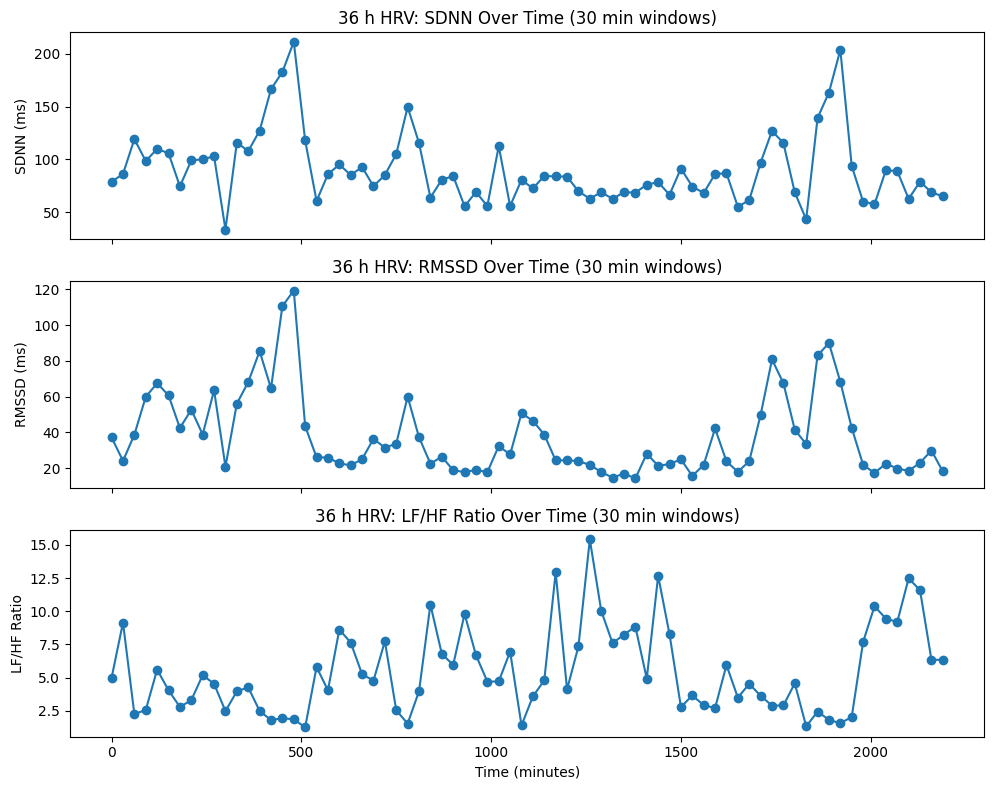

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the 30 min window metrics CSV
df = pd.read_csv("hrv_36h_30min_windows.csv")  # adjust path if needed

# 2. Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(df["start_min"], df["SDNN_ms"], marker="o")
axes[0].set_ylabel("SDNN (ms)")
axes[0].set_title("36 h HRV: SDNN Over Time (30 min windows)")

axes[1].plot(df["start_min"], df["RMSSD_ms"], marker="o")
axes[1].set_ylabel("RMSSD (ms)")
axes[1].set_title("36 h HRV: RMSSD Over Time (30 min windows)")

axes[2].plot(df["start_min"], df["LF_HF_ratio"], marker="o")
axes[2].set_ylabel("LF/HF Ratio")
axes[2].set_xlabel("Time (minutes)")
axes[2].set_title("36 h HRV: LF/HF Ratio Over Time (30 min windows)")

plt.tight_layout()
plt.show()


SDNN_ms: Day mean=94.65, Night mean=88.07, p=0.4219
RMSSD_ms: Day mean=36.68, Night mean=39.42, p=0.6183
LF_HF_ratio: Day mean=5.76, Night mean=5.21, p=0.4755


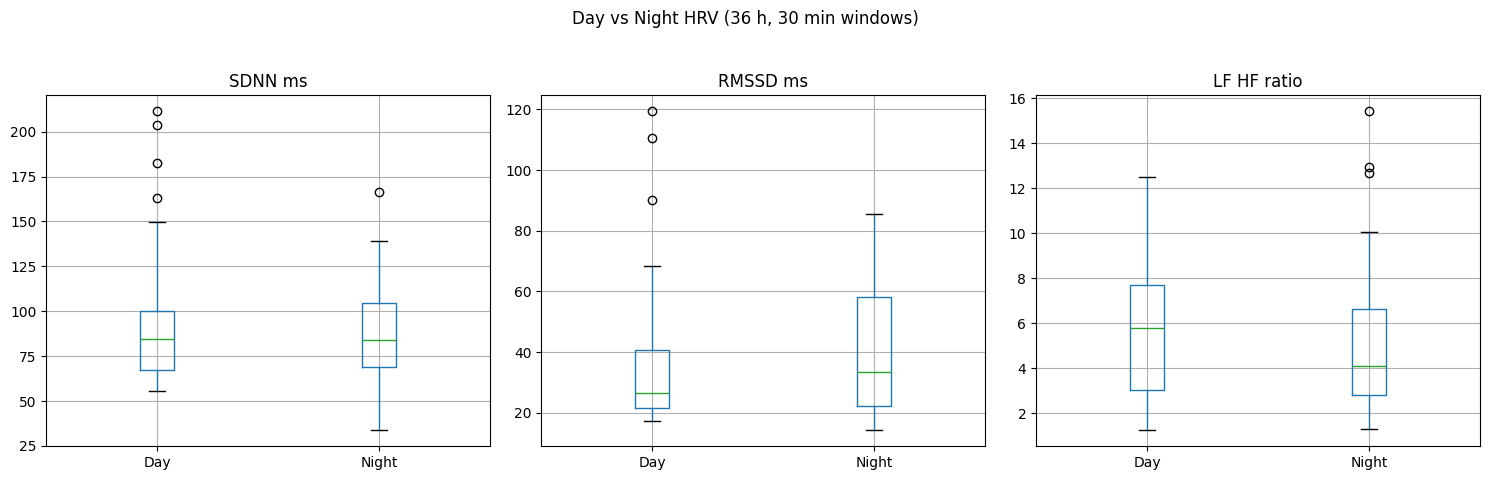

In [17]:
import mne
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo  # Python 3.9+

# 1) Load 36 h EDF and ECG
edf_path = "DATA/21-37-49_36 hours.EDF"
raw      = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
sf       = raw.info["sfreq"]
ecg_sig  = raw.get_data(picks="ECG")[0]
total_t  = raw.n_times / sf

# 2) Compute 30 min window metrics
win_s = 30 * 60
nwin  = int(total_t // win_s)
records = []

for w in range(nwin):
    start_s = w * win_s
    segment = ecg_sig[int(start_s*sf):int((start_s+win_s)*sf)]
    clean = nk.ecg_clean(segment, sampling_rate=sf, method="biosppy")
    _, info = nk.ecg_peaks(clean, sampling_rate=sf)
    rpeaks = info["ECG_R_Peaks"]
    if len(rpeaks) < 2:
        continue
    rr = np.diff(rpeaks) / sf * 1000
    sdnn  = np.std(rr, ddof=1)
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    fd    = nk.hrv_frequency(rpeaks, sampling_rate=sf,
                              psd_method="welch", normalize=True, show=False)
    lf_hf = float(fd["HRV_LFHF"].iloc[0])
    records.append({
        "start_sec":     start_s,
        "SDNN_ms":       sdnn,
        "RMSSD_ms":      rmssd,
        "LF_HF_ratio":   lf_hf
    })

df = pd.DataFrame(records)

# 3) Get recording start‐time and localize to Europe/Berlin
md = raw.info["meas_date"]
if isinstance(md, tuple):
    start_utc = datetime.fromtimestamp(md[0], tz=timezone.utc)
else:
    start_utc = (md.replace(tzinfo=timezone.utc)
                 if md.tzinfo is None else md.astimezone(timezone.utc))
start_loc = start_utc.astimezone(ZoneInfo("Europe/Berlin"))

# 4) Label Day vs Night
df["datetime"] = df["start_sec"].apply(lambda s: start_loc + timedelta(seconds=s))
df["hour"]     = df["datetime"].dt.hour
df["label"]    = np.where((df["hour"]>=6)&(df["hour"]<18), "Day", "Night")

# 5) t-tests and print
for metric in ["SDNN_ms","RMSSD_ms","LF_HF_ratio"]:
    d = df[df["label"]=="Day"][metric]
    n = df[df["label"]=="Night"][metric]
    t, p = ttest_ind(d, n, equal_var=False)
    print(f"{metric}: Day mean={d.mean():.2f}, Night mean={n.mean():.2f}, p={p:.4f}")

# 6) Boxplots
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ax, m in zip(axes, ["SDNN_ms","RMSSD_ms","LF_HF_ratio"]):
    df.boxplot(column=m, by="label", ax=ax)
    ax.set_title(m.replace("_"," "))
    ax.set_xlabel("")
plt.suptitle("Day vs Night HRV (36 h, 30 min windows)")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()
